# Building an inhibition-stabilised network 

Ta-Chu Kao and Guillaume Hennequin

### Introduction 

In this short tutorial, we build an inhibition-stabilised network (ISN), 
using a slightly modified algorithm from the one  previously described in 
[Hennequin et al., 2014](https://www.sciencedirect.com/science/article/pii/S0896627314003602).

### Network parameters and initialisation

We have a total of $n$ neurons, $n_e$ of which are excitatory and the other $n_i$ are inhibitory.
The network connectivity matrix $W$ can be written in block-matrix form as:
$$\begin{bmatrix}
W_{EE} & W_{EI} \\
W_{IE} & W_{II}
\end{bmatrix},$$
where $W_{EE}$ denotes the $E$ to $E$ connections, $W_{EI}$ the $I$ to $E$ connections and so on.

We initialise the network as follows: 
1. the probability of exc. neuron $i$ projecting to exc. neuron $j$ is $0 \leq p \leq 1$.
2. the excitatory weights are drawn from a lognormal distribution with mean $\log(w_0)$ and variance 1. 
3. the inhibitory synapses are drawn from a uniform distribution between -1 and 0 


### Stability optimization

During optimization, we minimise the spectral abscissa $\alpha$ until the network is thus stable (i.e., $\alpha < 1$).
We cannot use gradient descent to directly minimise the spectral abscissa because it is a discontinuous function with respect to the connectivity matrix $W$. Therefore, we choose instead to minimise the smoothed spectral abscissa $\alpha_\epsilon$, a quantity that upper bounds the spectral absissa and is a smooth function of the weights. Crucially, we only modifiy the inhibitory weights during training, keeping the excitatory connections fixed.
The method is described in detail in 
([Hennequin et al., 2014](https://www.sciencedirect.com/science/article/pii/S0896627314003602) and
[Vanbiervliet, 2007](https://epubs.siam.org/doi/abs/10.1137/070704034?mobileUi=0)).

The gradient of the smoothed spectral abscissa with respect to the connectivity matrix $W$ is given by

$$\displaystyle \frac{\partial \alpha_\epsilon(W)}{\partial W} = \frac{QP}{\text{tr}(QP)},$$

where $Q$ and $P$ and the observability and controllability Gramians of the system respectively.

Below, we use an adapative learning rate to speed up optimization. 

### Normalising inhibitory weights

Also, we normalise the inhibitory after each optimization step with the function `normalise` below,
which pins the DC mode of the system at $-10$. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# useful functions in lib.py
from lib import spectral_abscissa, Gramians 
from plotlib import plot_eig, load_plot_setting
load_plot_setting()

### Network and optimization parameters

In [2]:
n_e = 80 # number of excitatory neurons
n_i = 20  # number of inhibitory neurons
n = n_e + n_i  # number of neurons
p = 0.2 # excitatory connection density
radius = 2. # spectral radius
w0 = radius / np.sqrt(p * (1-p) * n) # excitatory synaptic strength 

# useful slicing functions to extract the relevant blocks of the connectivity matrix
e = slice(0,None),slice(0,n_e)
i = slice(0,None),slice(n_e,None)
ee = slice(0,n_e), slice(0,n_e)
ei = slice(0,n_e), slice(n_e,None)
ie = slice(n_e,None), slice(0,n_e)
ii = slice(n_e,None), slice(n_e,None)

### Normalising funciton

In [3]:
dc_eval = -10 # eigenvalue of DC mode
def normalise(W):
    W[i] = np.minimum(0, W[i])
    z = (dc_eval - np.sum(W, axis=1).reshape(-1,1)) / n_i
    W[i] = np.minimum(0, z + W[i])
    W = W - np.diag(np.diag(W))
    #np.fill_diagonal(W, 0)
    return W



### Initialising the connectivity matrix

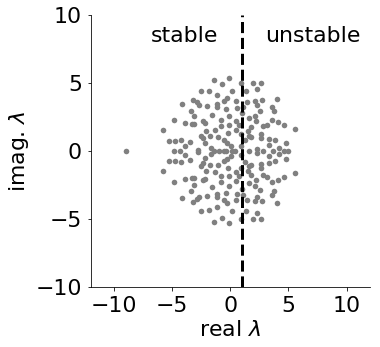

In [4]:
%matplotlib inline
def initialise():
    # initialise connectivity matrix with the right density
    W = np.random.lognormal(np.log(w0),1,size=[n,n])
    #build adjacency matrix of connections
    adjacency = np.random.uniform(0,1,size=[n,n_e])
    adjacency[adjacency>=p] = 2 # what is the point of 2 here?
    adjacency[adjacency<p] = 1
    adjacency[adjacency>1] = 0
    W[e] = W[e] * adjacency # remove silence percent of the synapses
    W[i] = -np.random.uniform(0,1,size=[n,n_i])

    W = W - np.diag(np.diag(W)) # remove self connections 
    # np.fill_diagonal(W, 0)
    W = normalise(W)
    return W 

W = initialise()
W_evals, _ = np.linalg.eig(W)

plot_eig(W_evals)

## Stability optimization

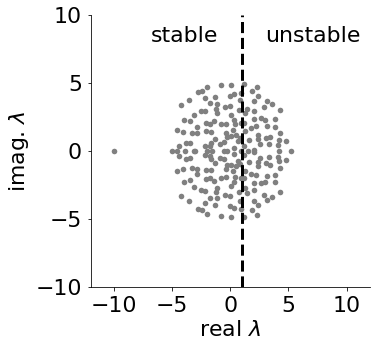

step   0 | spectral abscissa  5.134760 | shift: 6.161712 | learning rate: 1.000000 


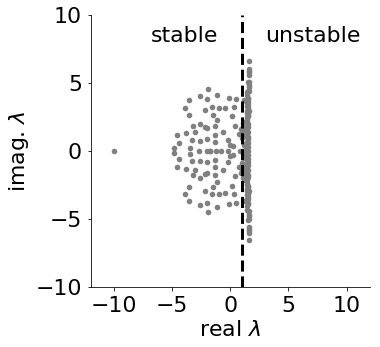

step 300 | spectral abscissa  1.630551 | shift: 1.956661 | learning rate: 1.445076 


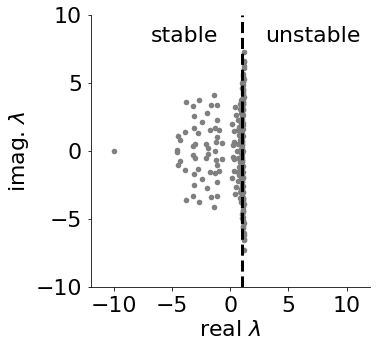

step 600 | spectral abscissa  1.182311 | shift: 1.418773 | learning rate: 1.010000 


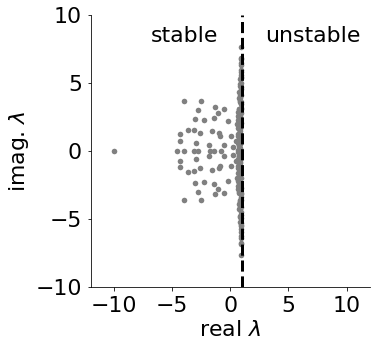

step 900 | spectral abscissa  0.961476 | shift: 1.153771 | learning rate: 1.769231 
FINAL spectral abscissa  0.899905


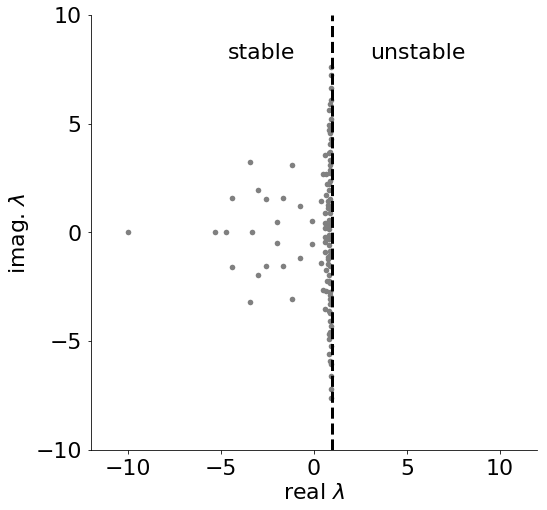

step 1200 | spectral abscissa  0.925948 | shift: 1.111138 | learning rate: 1.459527 
FINAL spectral abscissa  0.899708


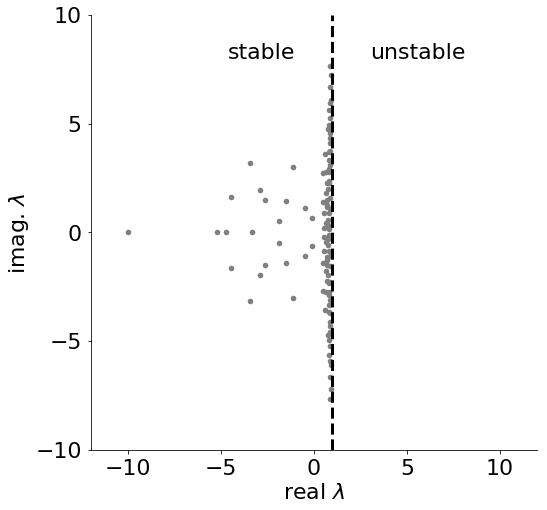

In [5]:
%matplotlib inline 
# initialise our matrix
W = initialise()
# optimisation parameters
n_iter = 5000 # number of training steps
threshold = 0.9 # stop optimization when spectral abscissa lower than threshold 
eta = 1  # initial learning rate
# optimisation flags
print_every = 300
plot_every = 300 
plt.ion()
# start stability optimization (takes about 1000 iterations)
for step in range(n_iter):
    s = spectral_abscissa(W) 
    if s < threshold: 
        print("FINAL spectral abscissa  %f" % s)
        W_evals, _ = np.linalg.eig(W)
        plot_eig(W_evals)
        break
    # adaptive learning rate
    eta = min(max(0.5 * eta if s > s_ else 1.01 * eta,1),8) if step > 0 else 1
    s_ = s # copy of spectral abscissa in this iteration for updating of learning rate in next iteration
    shift = max(1, 1.2*s) 
    A = W - shift * np.eye(n)
    Q = Gramians.obsv(A) # observability gramian
    P = Gramians.ctrl(A) # controllability gramian
    QP = Q.dot(P)
    dW = QP / np.trace(QP) # gradient of smoothed spectral abscissa with respect to W
    W[i]  = W[i] - eta * dW[i]
    W = normalise(W) # normalise W after each iteration
    if (step % plot_every) == 0:
        W_evals, _ = np.linalg.eig(W)
        plot_eig(W_evals)
    if step % print_every == 0:
        print("step %3i | spectral abscissa  %f | shift: %8f | learning rate: %f " % ((step,s,shift, eta)))

In [6]:
# Now let's save our inhibition stabilised network 
isn_name = "isn"
np.savetxt(f'{isn_name}_W.txt',W)
np.savetxt(f'{isn_name}_parameters.txt',[n_e, n_i, p, radius, w0])



You can now go back to **00_isn** to inspect the properties of the network you have just created.